In [1]:
import ipynb.fs.full.helper as h

from imp import reload
reload(h)

<module 'ipynb.fs.full.helper' (/tf/src/scripts/helper.ipynb)>

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2, keras

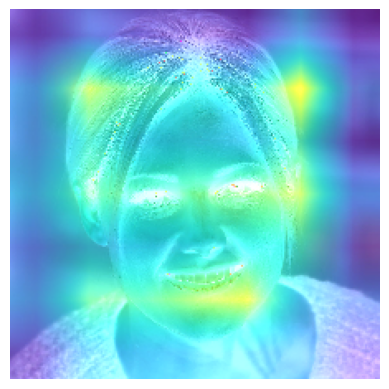

In [3]:
# Import explainer
from tf_explain.core.grad_cam import GradCAM
#from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

classifier = h.classifier


# Instantiation of the explainer
explainer = GradCAM()
#explainer = OcclusionSensitivity()

file_name = "fischer.jpg"
IMAGE_PATH = h.testsImages + "/" + file_name

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# index of label
class_index = 2

# Call to explain() method
output = explainer.explain(data, classifier, class_index=class_index)

output_dir = h.testsImages
output_name = f"GradCAM_{file_name}"

# Save output
explainer.save(output, output_dir, output_name)

plt.imshow(output)
plt.axis('off')
plt.show()

In [4]:
################################

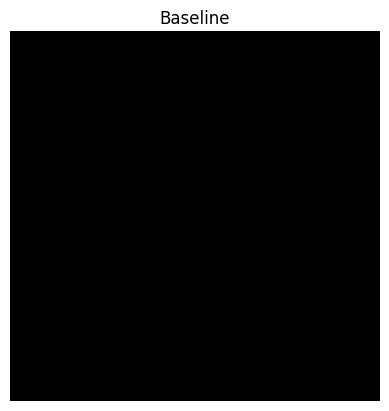

In [5]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [6]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [7]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [8]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [9]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=read_image(IMAGE_PATH),
    alphas=alphas)

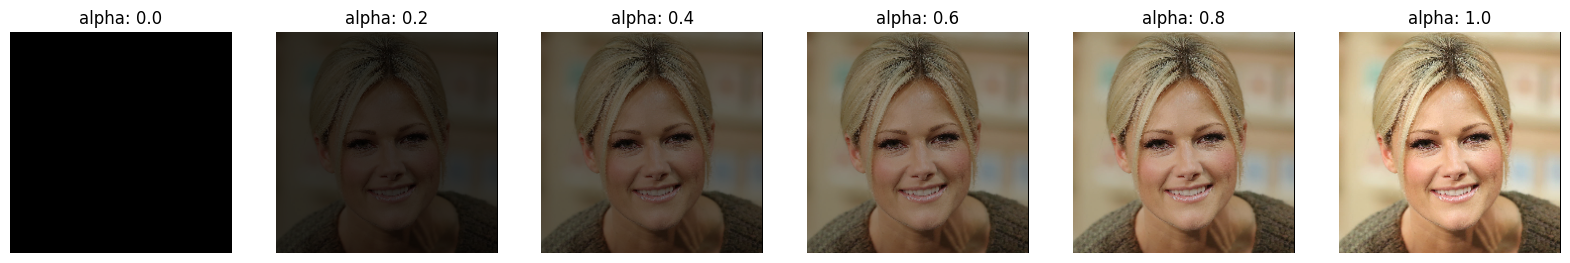

In [10]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.show()

In [11]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [12]:
model = classifier

In [13]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=class_index)

In [14]:
print(path_gradients.shape)

(51, 224, 224, 3)


In [15]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, class_index]

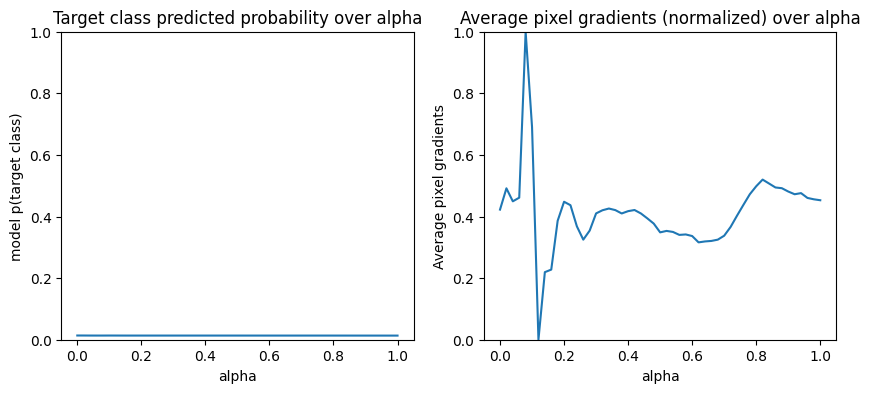

In [16]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

plt.show()

In [17]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [18]:
ig = integral_approximation(
    gradients=path_gradients)

In [19]:
print(ig.shape)

(224, 224, 3)


In [20]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Stack path gradients together row-wise into single tensor.
  total_gradients = tf.stack(gradient_batch)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [21]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [22]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=read_image(IMAGE_PATH),
                                       target_class_idx=class_index,
                                       m_steps=240)

In [23]:
output = f"{h.testsImages}/IntGrad_{file_name}"

In [24]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.savefig(output)
  plt.show()
  
  return fig

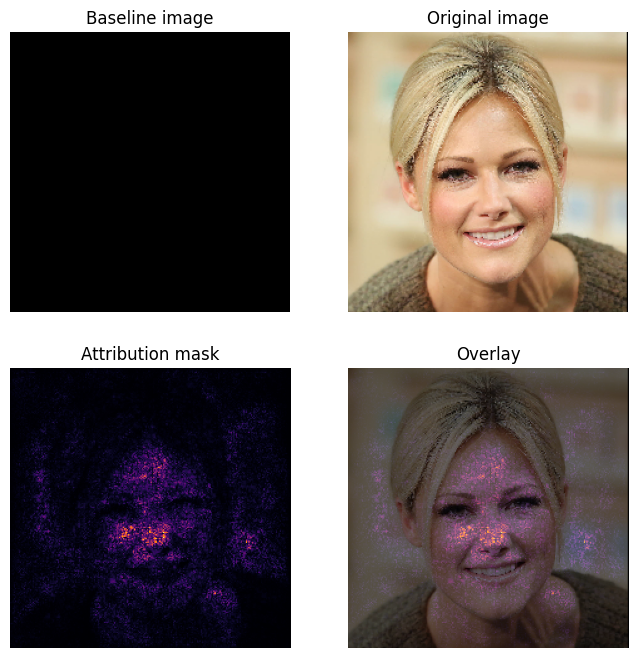

In [25]:
_ = plot_img_attributions(image=read_image(IMAGE_PATH),
                          baseline=baseline,
                          target_class_idx=class_index,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)